# Optimization and Simulation with DR

## ランダムサーチによる単目的関数の最適化

### 1. ライブラリ類のインポートとファイルのロード

In [1]:
%matplotlib inline

import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from pandas import DataFrame
from scipy.interpolate import griddata
import datarobot as dr

import japanize_matplotlib

if not os.getenv("DATAROBOT_NOTEBOOK_IMAGE"):
    print("not running in DataRobot Notebook")
    from dotenv import load_dotenv
    load_dotenv("../.env", override=True)

client = dr.Client()

seed = 71
np.random.seed(seed)
# sns.set_theme(style='darkgrid')
warnings.filterwarnings("ignore")

pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", 1000)
pd.set_option("display.width", 1000)
pd.set_option("display.max_colwidth", 1000)
pd.set_option("display.precision", 8)

not running in DataRobot Notebook


In [ ]:
deployment_id = "67bc6ab2f1b3f6b73d560ff8"
df = pd.read_csv("../data/opt_steel_strength.csv")

In [3]:
y_train = df["降伏強度"]
X_train = df.drop(["ID", "降伏強度", "引張強度"], axis=1)

In [4]:
# 312rows, 16columns
df.shape

(312, 16)

In [5]:
df.head()

,ID,炭素,マンガン,ケイ素,クロム,ニッケル,モリブデン,バナジウム,窒素,ニオブ,コバルト,タングステン,アルミニウム,チタン,降伏強度,引張強度
0,T0,0.02,0.05,0.05,0.01,19.70,2.95,0.01,0.00,0.01,15.00,0.00,0.15,1.55,2411.5,2473.5
1,T1,0.18,0.01,0.01,13.44,0.01,3.01,0.46,0.04,0.01,19.46,2.35,0.04,0.00,1123.1,1929.2
2,T2,0.00,0.01,0.01,8.67,13.45,0.82,0.01,0.00,0.01,13.90,0.00,0.39,0.57,1736.3,1871.8
3,T3,0.01,0.05,0.05,0.01,17.70,3.95,0.01,0.00,0.01,15.00,0.00,0.13,1.47,2487.3,2514.9
4,T4,0.01,0.05,0.05,0.01,19.40,1.45,0.01,0.00,0.01,14.90,0.00,0.13,1.55,2249.6,2315.0


### 2. 探索空間の指定とデータの生成

In [6]:
# 正規分布の上下を元データのmin, maxの少しだけ外側でトリムします。
n = 1000
X_artificial = DataFrame(index=range(n), columns=X_train.columns)

for col in X_artificial.columns:

    norm_dist = np.random.normal(X_train[col].mean(), X_train[col].std(), size=n)
    min_value = X_train[col].min()
    max_value = X_train[col].max()
    norm_dist = np.clip(norm_dist, min_value * 0.8, max_value * 1.2)

    X_artificial.loc[:, col] = norm_dist

X_artificial = pd.to_numeric(X_artificial.stack(), errors="coerce").unstack()

In [7]:
# csvに保存して、DataRobotで予測を行ってみましょう。
X_artificial.to_csv(
    "../data/opt_steel_strength_artificial_1000.csv", index=False, encoding="utf-8-sig"
)  # , encoding='SJIS'

### 予測
生成したDataFrameを用いて、DataRobotのバッチ予測で降伏強度を予測してみましょう。<br>
結果をExcelやpandas等でソートすることで、最も強度が高くなる条件が求まります。

In [8]:
_, df_result = dr.models.BatchPredictionJob.score_pandas(
    deployment=deployment_id, df=X_artificial
)

Streaming DataFrame as CSV data to DataRobot
Created Batch Prediction job ID 67bc0517d1b17663137001f7
Waiting for DataRobot to start processing
Job has started processing at DataRobot. Streaming results.


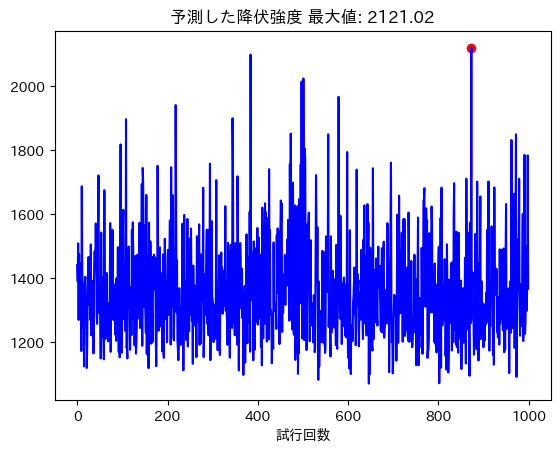

In [9]:
max_index = df_result["降伏強度_PREDICTION"].idxmax()
max_value = df_result["降伏強度_PREDICTION"].max()

df_result["降伏強度_PREDICTION"].plot(color="blue")
plt.scatter(max_index, max_value, color="red", marker="o")
plt.title(f"予測した降伏強度 最大値: {max_value:.2f}")
plt.xlabel("試行回数")
plt.show()

In [10]:
%%time
# 10,000件に増やしてもう一回やってみます。
n = 10000
X_artificial = DataFrame(index=range(n),
                         columns=X_train.columns)

for col in X_artificial.columns:

    norm_dist = np.random.normal(X_train[col].mean(), X_train[col].std(), size=n)
    min_value = X_train[col].min()
    max_value = X_train[col].max()
    norm_dist = np.clip(norm_dist, min_value * 0.8, max_value * 1.2)

    X_artificial.loc[:, col] = norm_dist
        
X_artificial = pd.to_numeric(X_artificial.stack(), errors='coerce').unstack()

CPU times: user 24.3 ms, sys: 7.52 ms, total: 31.8 ms
Wall time: 49.6 ms


In [11]:
X_artificial.to_csv(
    "../data/opt_steel_strength_artificial_10000.csv",
    index=False,
    encoding="utf-8-sig",
)  # , encoding='SJIS'

### 得られたデータ点の分布と予測結果の分布を可視化してみましょう

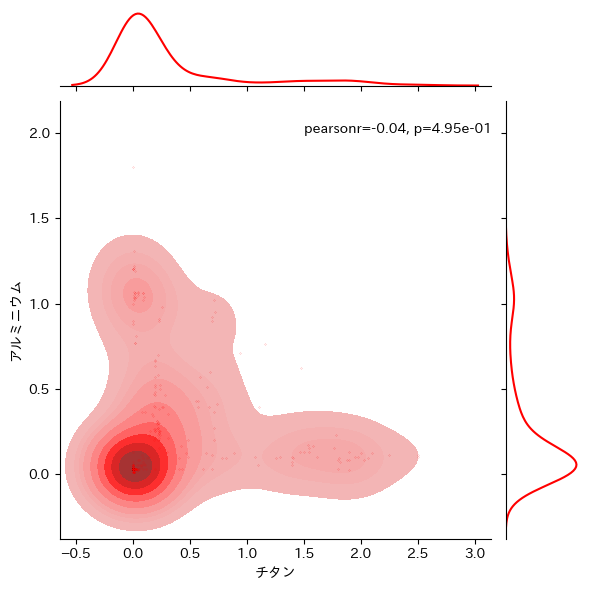

In [ ]:
# 元のデータの分布をみてみましょう。ここではチタンとアルミニウムについて可視化してみます。
feat_1 = "チタン"

feat_2 = "アルミニウム"

r, p = stats.pearsonr(X_train[feat_1], X_train[feat_2])
g = sns.JointGrid(data=X_train, x=feat_1, y=feat_2)
g.plot_joint(sns.kdeplot, fill=True, color="r")
g.plot_joint(plt.scatter, c="r", s=0.01)
g.plot_marginals(sns.kdeplot, color="r")
g.ax_joint.text(x=1.5, y=2, s=f"pearsonr={r:.2f}, p={p:.2e}")
g.set_axis_labels(feat_1, feat_2)

plt.show()

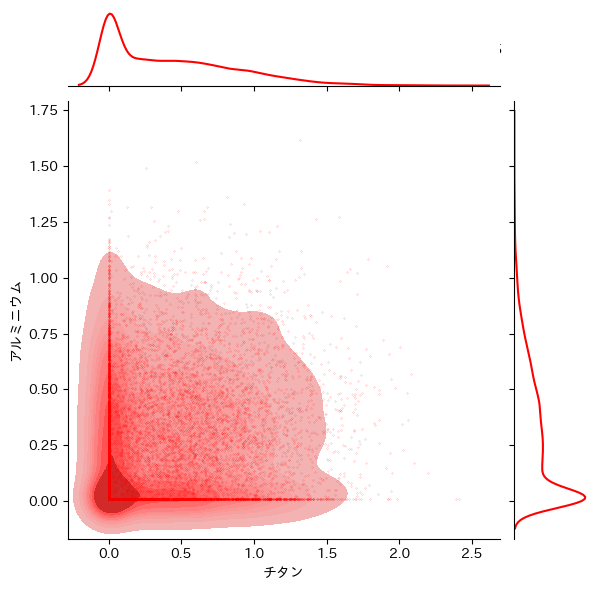

In [13]:
# 正規分布から生成したデータの分布をみてみましょう。
r, p = stats.pearsonr(X_artificial[feat_1], X_artificial[feat_2])
g = sns.JointGrid(data=X_artificial, x=feat_1, y=feat_2)
g.plot_joint(sns.kdeplot, fill=True, color="r")
g.plot_joint(plt.scatter, c="r", s=0.01)
g.plot_marginals(sns.kdeplot, color="r")
g.ax_joint.text(x=1.5, y=2, s=f"pearsonr={r:.4f}, p={p:.2F}")
g.set_axis_labels(feat_1, feat_2)

plt.show()

In [14]:
_, df_result = dr.models.BatchPredictionJob.score_pandas(
    deployment=deployment_id, df=X_artificial
)

Streaming DataFrame as CSV data to DataRobot
Created Batch Prediction job ID 67bc054ba2e682ef196d3947
Waiting for DataRobot to start processing
Job has started processing at DataRobot. Streaming results.


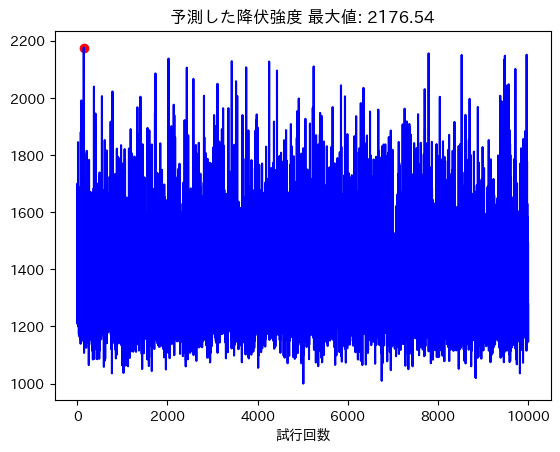

In [15]:
max_index = df_result["降伏強度_PREDICTION"].idxmax()
max_value = df_result["降伏強度_PREDICTION"].max()

df_result["降伏強度_PREDICTION"].plot(color="blue")
plt.scatter(max_index, max_value, color="red", marker="o")
plt.title(f"予測した降伏強度 最大値: {max_value:.2f}")
plt.xlabel("試行回数")
plt.show()

In [16]:
df_result.head()

,炭素,マンガン,ケイ素,クロム,ニッケル,モリブデン,バナジウム,窒素,ニオブ,コバルト,タングステン,アルミニウム,チタン,降伏強度_PREDICTION,DEPLOYMENT_APPROVAL_STATUS
0,0.18441891,0.00800000,0.00800000,9.31083746,8.54106047,0.01600000,0.00000000,0.01133176,0.00000000,8.94782921,0.51685383,0.00800000,0.39929500,1315.15930176,APPROVED
1,0.06370076,0.64095006,0.00800000,9.55166972,12.89244505,0.01600000,0.30758711,0.02060207,0.08836837,3.99823711,0.00000000,0.00800000,0.00000000,1243.51477051,APPROVED
2,0.05283816,0.00800000,1.26639190,20.30147950,8.70800011,3.41946135,0.00846817,0.00000000,0.06222824,0.00800000,0.00000000,0.30669377,0.54238295,1270.11901855,APPROVED
3,0.13233460,0.15914067,0.32138176,13.39810595,9.92621538,0.94329438,0.50631563,0.00000000,0.30493876,5.93803187,0.00000000,0.00800000,0.00000000,1210.26159668,APPROVED
4,0.00000000,0.00800000,0.00800000,13.61713012,6.91214534,3.01629912,0.10923618,0.01372550,0.24135819,13.67938252,0.00000000,0.19529972,0.71862078,1281.18103027,APPROVED


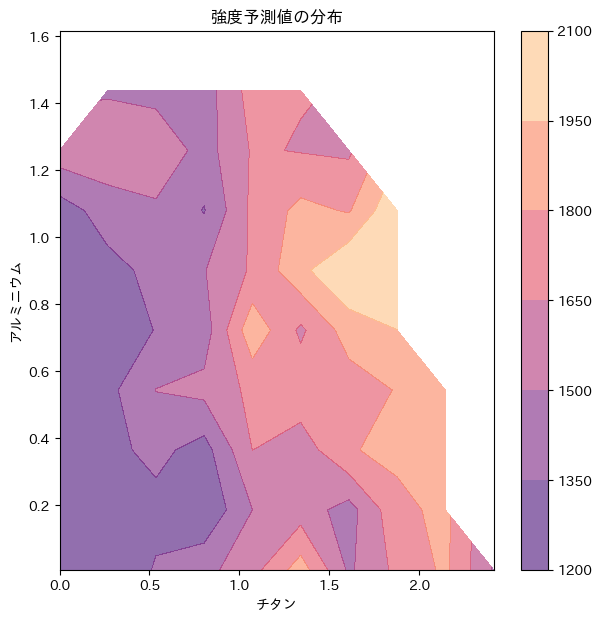

In [17]:
# 特徴空間（2D）における強度予測値の分布を可視化してみます
x = np.linspace(X_artificial[feat_1].min(), X_artificial[feat_1].max(), 10)
y = np.linspace(X_artificial[feat_2].min(), X_artificial[feat_2].max(), 10)

z = griddata(
    (X_artificial[feat_1].values, X_artificial[feat_2].values),
    df_result["降伏強度_PREDICTION"].values,
    (x[None, :], y[:, None]),
    method="linear",
)

plt.figure(figsize=[7, 7])
plt.contourf(x, y, z, 5, alpha=0.6, cmap=plt.cm.magma)
plt.colorbar()
plt.clim(df_result["降伏強度_PREDICTION"].min(), df_result["降伏強度_PREDICTION"].max())
plt.xlabel(feat_1)
plt.ylabel(feat_2)
plt.title("強度予測値の分布")
plt.show()

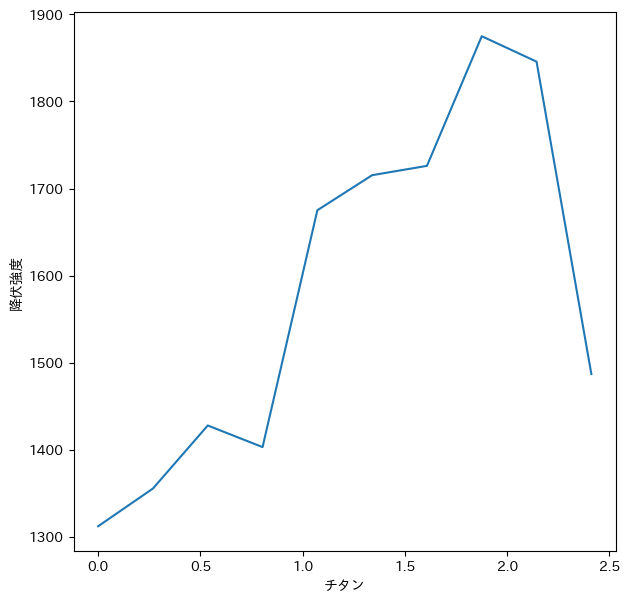

In [18]:
plt.figure(figsize=[7, 7])
plt.plot(x, np.nanmean(z, axis=0))
plt.xlabel(feat_1)
plt.ylabel("降伏強度")
plt.show()

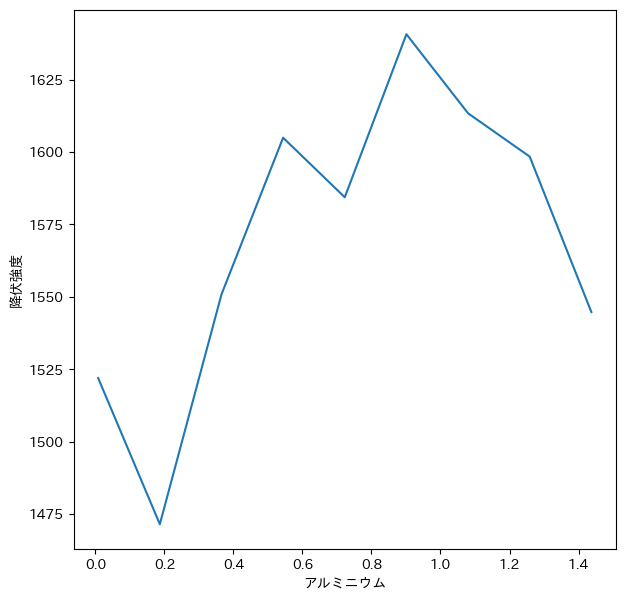

In [19]:
plt.figure(figsize=[7, 7])
plt.plot(y, np.nanmean(z, axis=1))
plt.xlabel(feat_2)
plt.ylabel("降伏強度")
plt.show()